In [3]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))


In [4]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import *
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import seaborn

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [170]:
#functions 

def player_return(utility_func, plays, system_vals, pi_cp):
    #indicator_vec = vec_softmax(system_vals)
    cp_round = np.argmax(system_vals)
    cp_cost = pi_cp*plays[cp_round]
    rev = np.sum(utility_func(plays))
    out = rev - cp_cost
    return(out)

def vec_softmax(system_vals, beta=20):
    #system_vals must be numpy array
    if type(np.array([1])) != np.ndarray:
        print("System values not numpy array")
    else:
        #large beta approximates argmax indicator vector
        numer = np.exp(beta*system_vals)
        denom = np.sum(np.exp(beta*system_vals))
        out = (1.0/denom)*numer
        return(out)
    
def player_linear_utility_lambda(a=1):
    return(lambda x: a*x)
    
def player_utility_lambda(a=1):
    return(lambda x: a*np.log(1 + x))

def player_d_utility_lambda(a=1):
    return(lambda x: a/(1 + x))

def player_dd_utility_lambda(a=1):
    return(lambda x: -a/np.power(1 + x, 2))

### Empirical max bound

In [295]:
#empirical bound on max over sequence of length T, 0 mean unit variance

MC = 10000
T = 20
emp_bound = []
upper_ineq_bound = []
lower_ineq_bound = []
FTG_bound = []
gamma = 0.57721

for t in range(T):
    maxes = []
    for m in range(MC):
        p = np.random.normal(0, 1, size=(1,t+2))
        max_play = np.max(p)
        maxes.append(max_play)
    emp_bound.append(np.mean(maxes))
    upper_ineq_bound.append(np.sqrt(2*np.log(t+2)))
    lower_ineq_bound.append(0.23*np.sqrt(np.log(t+2)))
    FTG_bound.append(np.sqrt(np.log(np.power(t+2, 2)/(2*np.pi*np.log(np.power(t+2,2)/2*np.pi)))) * (1 + (gamma/np.log(t+2)))) #+ o(1/np.log(t+2))

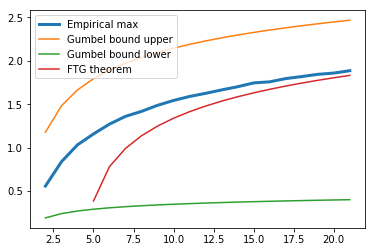

In [298]:
plt.plot(np.asarray([i+2 for i in range(T)]), np.asarray(emp_bound), label="Empirical max", lw=3)
plt.plot(np.asarray([i+2 for i in range(T)]), np.asarray(upper_ineq_bound), label="Gumbel bound upper")
plt.plot(np.asarray([i+2 for i in range(T)]), np.asarray(lower_ineq_bound), label="Gumbel bound lower")
plt.plot(np.asarray([i+2 for i in range(T)]), np.asarray(FTG_bound), label="FTG theorem")
plt.legend()
plt.show()

In [ ]:
#15 rounds is close, fix T = 15 and increase variance

In [301]:
MC = 10000
t = 15
variances = np.arange(1.0,5.01,0.01) #standard deviation
emp_bound = []
upper_ineq_bound = []
lower_ineq_bound = []
FTG_bound = []
gamma = 0.57721

for v in variances:
    maxes = []
    for m in range(MC):
        p = np.random.normal(0, v, size=(1,t))
        max_play = np.max(p)
        maxes.append(max_play)
    emp_bound.append(np.mean(maxes))
    upper_ineq_bound.append(v*np.sqrt(2*np.log(t)))
    lower_ineq_bound.append(v*0.23*np.sqrt(np.log(t)))
    FTG_bound.append(np.sqrt(np.log(np.power(t, 2)/(2*np.pi*np.log(np.power(t,2)/2*np.pi)))) * (1 + (gamma/np.log(t)))) #+ o(1/np.log(t+2))

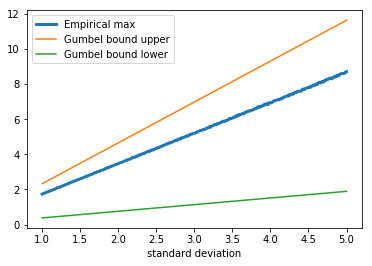

In [303]:
plt.plot(variances, np.asarray(emp_bound), label="Empirical max", lw=3)
plt.plot(variances, np.asarray(upper_ineq_bound), label="Gumbel bound upper")
plt.plot(variances, np.asarray(lower_ineq_bound), label="Gumbel bound lower")
#plt.plot(variances, np.asarray(FTG_bound), label="FTG theorem") #need to include variance
plt.xlabel("standard deviation")
plt.legend()
plt.show()

### Uncorrelated

two rounds, two players for all scenarios

In [304]:
#loop through one player's variance, Gaussian
#look at expected payoff as a function of variance
#linear utility

p_util = player_linear_utility_lambda(0)
q_util = player_linear_utility_lambda(0)

pi_cp = 1

variance = np.arange(0.01, 1.01, 0.01)

MC = 10000

p_rev_exps = []
q_rev_exps = []

for v in variance:
    p_revs = []
    q_revs = []
    for m in range(MC):
        p = np.random.normal(10, v, size=(1,2))
        q = np.random.normal(10, 1, size=(1,2))
        s = p + q
        plays = np.vstack((p, q, s))
        
        p_revs.append(player_return(p_util, plays[0,:], plays[2,:], pi_cp))
        q_revs.append(player_return(q_util, plays[1,:], plays[2,:], pi_cp))
        
    p_rev_exps.append(np.nanmean(p_revs))
    q_rev_exps.append(np.nanmean(q_revs))

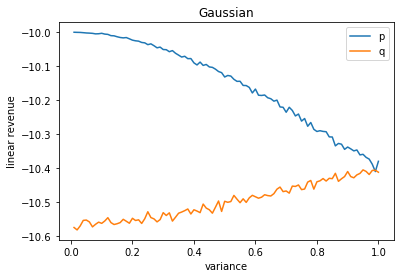

In [305]:
plt.plot(variance, p_rev_exps, label="p")
plt.plot(variance, q_rev_exps, label="q")
plt.title("Gaussian")
plt.xlabel("variance")
plt.ylabel("linear revenue")
plt.legend()
plt.show()

In [306]:
#loop through one player's range, uniform random variable
#look at expected payoff as a function of variance
#linear utility

p_util = player_linear_utility_lambda()
q_util = player_linear_utility_lambda()

pi_cp = 1.2

variance = np.arange(10.1, 20.1, 0.1)

MC = 1000

p_rev_exps = []
q_rev_exps = []

for v in variance:
    p_revs = []
    q_revs = []
    for m in range(MC):
        p = np.random.uniform(10, v, size=(1,2))
        q = np.random.uniform(10, 15, size=(1,2))
        s = p + q
        plays = np.vstack((p, q, s))
        
        p_revs.append(player_return(p_util, plays[0,:], plays[2,:], pi_cp))
        q_revs.append(player_return(q_util, plays[1,:], plays[2,:], pi_cp))
        
    p_rev_exps.append(np.nanmean(p_revs))
    q_rev_exps.append(np.nanmean(q_revs))

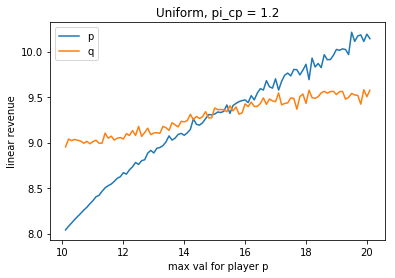

In [307]:
plt.plot(variance, p_rev_exps, label="p")
plt.plot(variance, q_rev_exps, label="q")
plt.title("Uniform, pi_cp = " + str(pi_cp))
plt.xlabel("max val for player p")
plt.ylabel("linear revenue")
plt.legend()
plt.show()

In [308]:
#loop through one player's range, uniform random variable
#look at expected payoff as a function of variance
#linear utility

p_util = player_linear_utility_lambda()
q_util = player_linear_utility_lambda()

pi_cp = 1.8

variance = np.arange(10.1, 20.1, 0.1)

MC = 1000

p_rev_exps = []
q_rev_exps = []

for v in variance:
    p_revs = []
    q_revs = []
    for m in range(MC):
        p = np.random.uniform(10, v, size=(1,2))
        q = np.random.uniform(10, 15, size=(1,2))
        s = p + q
        plays = np.vstack((p, q, s))
        
        p_revs.append(player_return(p_util, plays[0,:], plays[2,:], pi_cp))
        q_revs.append(player_return(q_util, plays[1,:], plays[2,:], pi_cp))
        
    p_rev_exps.append(np.nanmean(p_revs))
    q_rev_exps.append(np.nanmean(q_revs))

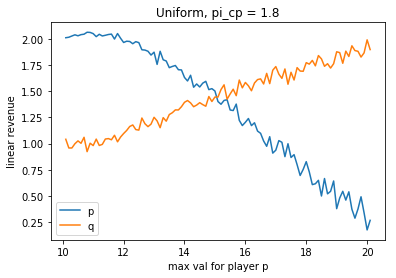

In [309]:
plt.plot(variance, p_rev_exps, label="p")
plt.plot(variance, q_rev_exps, label="q")
plt.title("Uniform, pi_cp = " + str(pi_cp))
plt.xlabel("max val for player p")
plt.ylabel("linear revenue")
plt.legend()
plt.show()

In [310]:
#loop through one player's range, uniform random variable
#look at expected payoff as a function of variance
#linear utility

p_util = player_linear_utility_lambda()
q_util = player_linear_utility_lambda()

pi_cp = 2.0 #turns strictly non-positive at 2.0

variance = np.arange(10.1, 20.1, 0.1)

MC = 1000

p_rev_exps = []
q_rev_exps = []

for v in variance:
    p_revs = []
    q_revs = []
    for m in range(MC):
        p = np.random.uniform(10, v, size=(1,2))
        q = np.random.uniform(10, 15, size=(1,2))
        s = p + q
        plays = np.vstack((p, q, s))
        
        p_revs.append(player_return(p_util, plays[0,:], plays[2,:], pi_cp))
        q_revs.append(player_return(q_util, plays[1,:], plays[2,:], pi_cp))
        
    p_rev_exps.append(np.nanmean(p_revs))
    q_rev_exps.append(np.nanmean(q_revs))

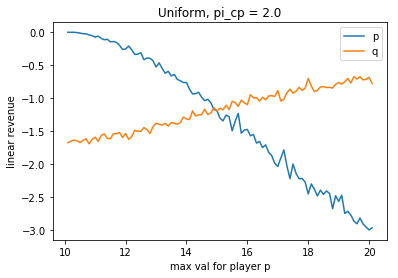

In [311]:
plt.plot(variance, p_rev_exps, label="p")
plt.plot(variance, q_rev_exps, label="q")
plt.title("Uniform, pi_cp = " + str(pi_cp))
plt.xlabel("max val for player p")
plt.ylabel("linear revenue")
plt.legend()
plt.show()

### Positively Correlated

In [312]:
#player p rewards as function variance of p
#linear case, assume players are correlated by linear dependence

In [313]:
#loop through one player's variance, Gaussian

p_util = player_linear_utility_lambda()
q_util = player_linear_utility_lambda()

pi_cp = 1.2

variance = np.arange(0.25, 2.01, 0.01) #minimum of 0.25

MC = 1000

p_rev_exps = []
p_stds = []
q_rev_exps = []
q_stds = []

for v in variance:
    p_revs = []
    q_revs = []
    for m in range(MC):
        r1 = np.random.multivariate_normal(np.array([10, 10]), np.array([[v, 0.5],
                                                                         [0.5, 1.0]]))
        r2 = np.random.multivariate_normal(np.array([10, 10]), np.array([[v, 0.5],
                                                                         [0.5, 1.0]]))
        r = np.vstack((r1, r2)).T
        #p = np.random.normal(10, v, size=(1,2))
        #q = p + np.random.normal(0,1, size=(1,2))
        s = r[0,:] + r[1, :]
        plays = np.vstack((r, s))
        
        p_revs.append(player_return(p_util, plays[0,:], plays[2,:], pi_cp))
        q_revs.append(player_return(q_util, plays[1,:], plays[2,:], pi_cp))
        
    p_rev_exps.append(np.nanmean(p_revs))
    p_stds.append(np.nanvar(p_revs))
    q_rev_exps.append(np.nanmean(q_revs))
    q_stds.append(np.nanvar(q_revs))

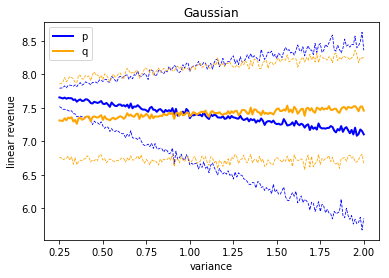

In [314]:
plt.plot(variance, p_rev_exps, label="p", color="blue", lw=2)
plt.plot(variance, np.asarray(p_rev_exps) + np.asarray(p_stds), '--', color="blue", lw=0.8)
plt.plot(variance, np.asarray(p_rev_exps) - np.asarray(p_stds), '--', color="blue", lw=0.8)
plt.plot(variance, q_rev_exps, label="q", color="orange", lw=2)
plt.plot(variance, np.asarray(q_rev_exps) + np.asarray(q_stds), '--', color="orange", lw=0.8)
plt.plot(variance, np.asarray(q_rev_exps) - np.asarray(q_stds), '--', color="orange", lw=0.8)
plt.title("Gaussian")
plt.xlabel("variance")
plt.ylabel("linear revenue")
plt.legend()
plt.show()

### Negatively Correlated

In [315]:
#loop through one player's variance, Gaussian

p_util = player_linear_utility_lambda()
q_util = player_linear_utility_lambda()

pi_cp = 1.2

variance = np.arange(0.25, 2.01, 0.01) #PSD starts at 0.25 with 0.5 off diagonal

MC = 1000

p_rev_exps = []
p_stds = []
q_rev_exps = []
q_stds = []

for v in variance:
    p_revs = []
    q_revs = []
    for m in range(MC):
        r1 = np.random.multivariate_normal(np.array([10, 10]), np.array([[v, -0.5],
                                                                         [-0.5, 1.0]])) #[p1, q1]
        r2 = np.random.multivariate_normal(np.array([10, 10]), np.array([[v, -0.5],
                                                                         [-0.5, 1.0]])) #[p1, q2]
        r = np.vstack((r1, r2)).T
        #p = np.random.normal(10, v, size=(1,2))
        #q = p + np.random.normal(0,1, size=(1,2))
        s = r[0,:] + r[1, :]
        plays = np.vstack((r, s))
        
        p_revs.append(player_return(p_util, plays[0,:], plays[2,:], pi_cp))
        q_revs.append(player_return(q_util, plays[1,:], plays[2,:], pi_cp))
        
    p_rev_exps.append(np.nanmean(p_revs))
    p_stds.append(np.nanvar(p_revs))
    q_rev_exps.append(np.nanmean(q_revs))
    q_stds.append(np.nanvar(q_revs))

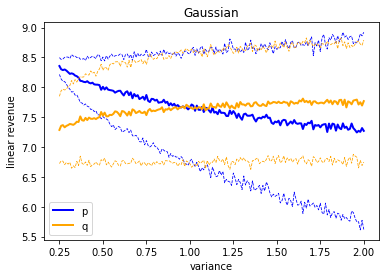

In [316]:
plt.plot(variance, p_rev_exps, label="p", color="blue", lw=2)
plt.plot(variance, np.asarray(p_rev_exps) + np.asarray(p_stds), '--', color="blue", lw=0.8)
plt.plot(variance, np.asarray(p_rev_exps) - np.asarray(p_stds), '--', color="blue", lw=0.8)
plt.plot(variance, q_rev_exps, label="q", color="orange", lw=2)
plt.plot(variance, np.asarray(q_rev_exps) + np.asarray(q_stds), '--', color="orange", lw=0.8)
plt.plot(variance, np.asarray(q_rev_exps) - np.asarray(q_stds), '--', color="orange", lw=0.8)
plt.title("Gaussian")
plt.xlabel("variance")
plt.ylabel("linear revenue")
plt.legend()
plt.show()

### System Perspective ; Perfect Prediction w/o signal

In [ ]:
#monte carlo
    #realize sequence of x_t
    #for K-CP
        #reduce K-CP's by budget delta
        

### System Perspective ; Perfect Prediction w/ signal

In [381]:
#players are equal size and have infinite peak reduction budget
MC = 100000

expected_true_peaks = []
expected_reduced_peaks = []
expected_diffs = []

for T in range(2,100): #> 12 FTG starts to converge to empirical max
    for i in range(1):
        #peak_reductions = [] #need to do these for each of top k?
        true_peaks = []
        reduced_peaks = []
        diffs = []
        for mc in range(MC):
            #realize the player sequences
            p1 = np.random.normal(0,1,size=(1,T))
            p2 = np.random.normal(0,1,size=(1,T))
            sys = p1 + p2

            #get arguments of top i peaks
            top_i = list(reversed(np.argsort(sys)[0,-(i+1):]))

            #players curtail peaks by 1/N
            curtailed_sys = copy.copy(sys)
            curtailed_p1 = copy.copy(p1)
            curtailed_p2 = copy.copy(p2)
            for index in top_i:
                cp_val = sys[0,index]
                true_peaks.append(cp_val)
                prev = sys[0,0:index] #everything up to the index
                if index == 0:
                    reduced_peaks.append(cp_val)
                    pass  #no previous actions to reduce to
                else:
                    prior_max = np.max(prev)
                    diff = cp_val - prior_max
                    diffs.append(diff)
                    
                    player_curtail = 0.5*diff

                    curtailed_sys[0,index] = prior_max
                    curtailed_p1[0,index] = p1[0,index] - player_curtail
                    curtailed_p2[0,index] = p2[0,index] - player_curtail
                    
                    reduced_peaks.append(np.max(curtailed_sys)) #new peak can be later that prior_max
    
    expected_true_peaks.append(np.mean(np.asarray(true_peaks)))
    expected_reduced_peaks.append(np.mean(np.asarray(reduced_peaks)))
    expected_diffs.append(np.mean(np.asarray(diffs)))

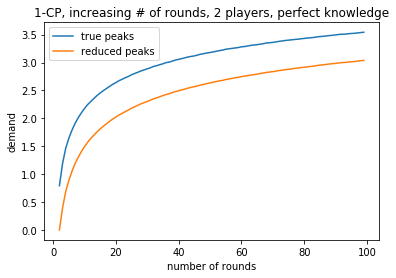

In [390]:
plt.plot(np.arange(2,100,1), np.asarray(expected_true_peaks), label="true peaks")
plt.plot(np.arange(2,100,1), np.asarray(expected_reduced_peaks), label="reduced peaks")
plt.xlabel("number of rounds")
plt.ylabel("demand")
plt.title("1-CP, increasing # of rounds, 2 players, perfect knowledge")
plt.legend()
plt.show()

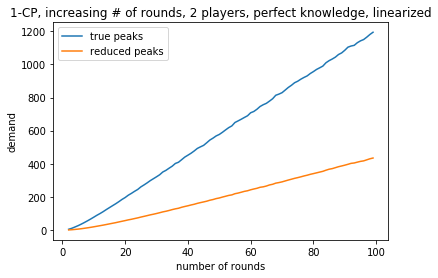

In [391]:
plt.plot(np.arange(2,100,1), np.exp(2*np.asarray(expected_true_peaks)), label="true peaks")
plt.plot(np.arange(2,100,1), np.exp(2*np.asarray(expected_reduced_peaks)), label="reduced peaks")
plt.xlabel("number of rounds")
plt.ylabel("demand")
plt.title("1-CP, increasing # of rounds, 2 players, perfect knowledge, linearized")
plt.legend()
plt.show()

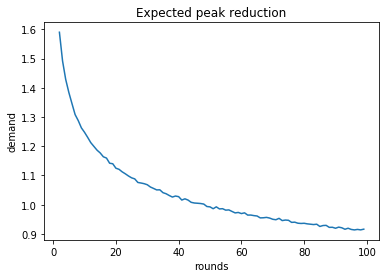

In [383]:
plt.plot(np.arange(2,100,1), expected_diffs)
plt.title("Expected peak reduction")
plt.ylabel("demand")
plt.xlabel("rounds")
plt.show()

In [385]:
sorted(top_i + [2])

[2, 37]

In [480]:
#fix T, cycle through number of peaks
T = 40

#players are equal size and have infinite peak reduction budget
MC = 100000

expected_true_peaks = []
expected_true_peaks_sorted = []
expected_reduced_peaks = []
expected_diffs = []
top_10_mc = []

for i in range(0,19): #number of peaks considered
    #peak_reductions = [] #need to do these for each of top k?
    true_peaks = []
    true_peaks_sorted = []
    reduced_peaks = []
    diffs = []
    for mc in range(MC):
        reduced_peaks_mc = []
        true_peaks_mc = []
        diffs_mc = []
        
        #realize the player sequences
        p1 = np.random.normal(0,1,size=(1,T))
        p2 = np.random.normal(0,1,size=(1,T))
        sys = p1 + p2

        #get arguments of top i peaks
        #sort top_i chronologically in order to be peak size agnostic
        top_i = sorted(list(reversed(np.argsort(sys)[0,-(i+1):])))
        top_10_mc.append(list(sys[0,np.array(list(reversed(np.argsort(sys)[0,-10:])))]))
        
        
        #players curtail peaks by 1/N
        curtailed_sys = copy.copy(sys)
        curtailed_p1 = copy.copy(p1)
        curtailed_p2 = copy.copy(p2)
        for index in top_i:
            cp_val = sys[0,index]
            true_peaks_mc.append(cp_val)
            prev = curtailed_sys[0,0:index] #everything up to the index with updated previous peaks
            if index == 0:
                reduced_peaks_mc.append(cp_val)
                diffs_mc.append(0)
                pass  #no previous actions to reduce to
            else:
                #if system detects binary yes/no is top-k peak, then broadcast to reduce to closest previous peak
                prior_max = np.max(prev)
                diff = cp_val - prior_max
                diffs_mc.append(diff)

                player_curtail = 0.5*diff

                curtailed_sys[0,index] = prior_max
                curtailed_p1[0,index] = p1[0,index] - player_curtail
                curtailed_p2[0,index] = p2[0,index] - player_curtail

                reduced_peaks_mc.append(np.max(curtailed_sys)) #new peak can be later that prior_max
        
        true_peaks.append(true_peaks_mc)
        true_peaks_sorted.append(sorted(true_peaks_mc))
        reduced_peaks.append(reduced_peaks_mc)
        diffs.append(diffs_mc)

    expected_true_peaks.append(np.mean(np.asarray(true_peaks), axis=0))
    expected_true_peaks_sorted.append(np.mean(np.asarray(true_peaks_sorted), axis=0))
    expected_reduced_peaks.append(np.mean(np.asarray(reduced_peaks), axis=0))
    expected_diffs.append(np.mean(np.asarray(diffs), axis=0))

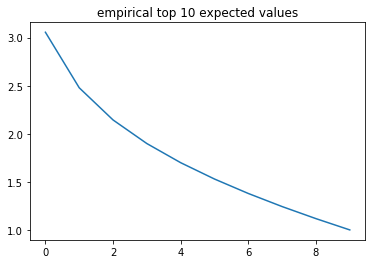

In [481]:
plt.plot(np.mean(np.asarray(top_10_mc), axis=0))
plt.title("empirical top 10 expected values")
plt.show()

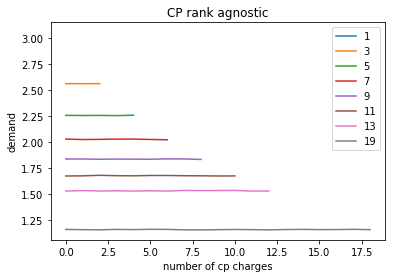

In [482]:
peaks = [0, 2, 4, 6, 8, 10, 12, 18]
for p in peaks:
    plt.plot(expected_true_peaks[p], label=str(p+1))
plt.legend()
plt.xlabel("number of cp charges")
plt.ylabel("demand")
plt.title("CP rank agnostic")
plt.show()

#CP values occur uniformly at random, these are the averages of all CP values given the number of peaks considered

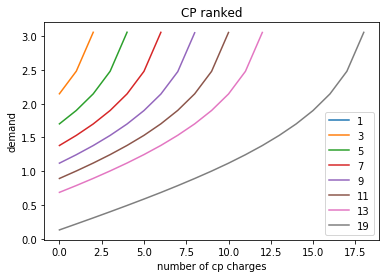

In [483]:
peaks = [0, 2, 4, 6, 8, 10, 12, 18]
for p in peaks:
    plt.plot(expected_true_peaks_sorted[p], label=str(p+1))
plt.legend()
plt.xlabel("number of cp charges")
plt.ylabel("demand")
plt.title("CP ranked")
plt.show()

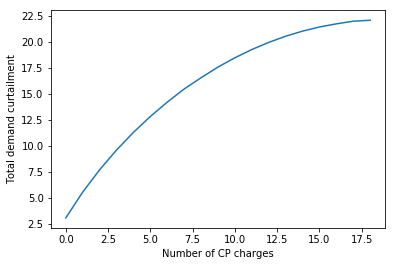

In [484]:
#total curtailement by n-cp
sum_curtailed = []
for arr in expected_true_peaks_sorted:
    sum_curtailed.append(np.sum(arr))

plt.plot(np.arange(0,19,1), sum_curtailed)
plt.xlabel("Number of CP charges")
plt.ylabel("Total demand curtailment")
plt.show()

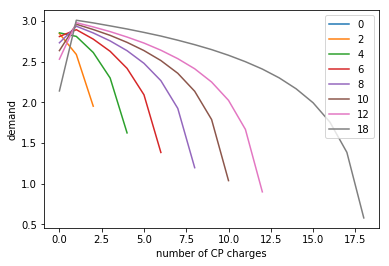

In [470]:
for p in peaks:
    plt.plot(expected_reduced_peaks[p], label=str(p))
plt.legend()
plt.ylabel("demand")
plt.xlabel("number of CP charges")
plt.show()

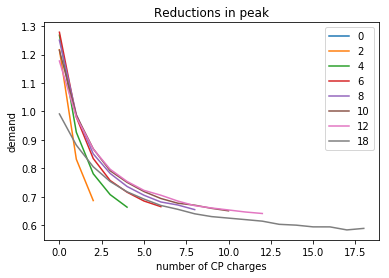

In [471]:
for p in peaks:
    plt.plot(expected_diffs[p], label=str(p))
plt.legend()
plt.title("Reductions in peak")
plt.ylabel("demand")
plt.xlabel("number of CP charges")
plt.show()

### Player reduction budget
### Reduce mean, reduce variance

In [ ]:
#need to consider different player curtailment strategies  #players have equal finite budgets
#need to consider uncertainty in system CP signals
#positive and negative correlation

### E[cp_1] - E[cp_2] = E[cp_1 - cp_2]

In [27]:
expected_diff = []
T = 20

for t in range(2,T):
    sig_1_mc = []
    sig_2_mc = []
    diff_mc = []

    for mc in range(MC):
        X = np.random.normal(0,1,size=(t,))
        top_i = list(reversed(np.argsort(X)))
        sig_1 = X[top_i[0],]
        sig_2 = X[top_i[1],]
        diff = sig_1 - sig_2

        sig_1_mc.append(sig_1)
        sig_2_mc.append(sig_2)
        diff_mc.append(diff)
        
    expected_diff.append(np.mean(diff_mc))

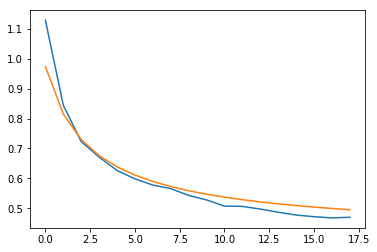

In [37]:
plt.plot(expected_diff)
plt.plot(1/np.power(np.arange(2,20),0.8)+0.4)

### Simple reduction of top K-CP by \Delta / K

In [5]:
#for a given peak reduction budget \Delta, reduce the top K peaks according to \Delta/K

budget_surf = np.zeros((50,40))
T = 41
deltas = np.arange(0.2,10.2,0.2)
MC = 10000

for j in range(deltas.shape[0]):
    delta = deltas[j]
    expected_peaks = []
    for k in range(1,T):
        peak_mc = []
        for mc in range(MC):
            X = np.random.normal(0,1,size=(T,))
            top_i = list(reversed(np.argsort(X)))
            for cp in range(k):
                X[top_i[cp]] = X[top_i[cp]] - float(delta/float(k))
            peak_mc.append(np.max(X))
        expected_peaks.append(np.mean(peak_mc))
    budget_surf[j,:] = expected_peaks


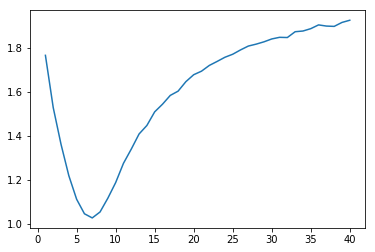

In [6]:
#when budget is larger than expected difference between sig_1 and sig_2, the extra budget is superfluous
plt.plot(np.arange(1,T,1), expected_peaks)
#plt.plot((1/np.arange(2,20))+1)
plt.show()

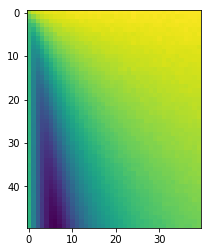

In [7]:
plt.imshow(budget_surf)

<IPython.core.display.Javascript object>


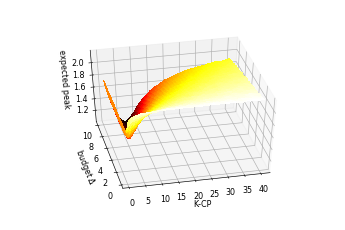

In [9]:
##need to plot surface instead of imshow
%matplotlib notebook

Y = np.arange(0.2,10.2,0.2)
X = np.arange(1,T,1)
X, Y = np.meshgrid(X, Y)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, budget_surf, rstride=1, cstride=1, cmap='hot', linewidth=0, antialiased=False)
#ax.set_zlim(-1.01, 1.01)
ax.set_xlabel('K-CP')
ax.set_ylabel('budget $\Delta$')
ax.set_zlabel('expected peak')

#fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

<IPython.core.display.Javascript object>


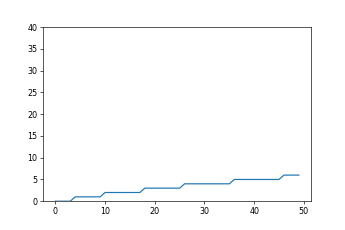

In [12]:
#plot minimum peak CP for each budget 
best_cp = []
for i in range(len(deltas)):
    best_cp.append(np.argmin(budget_surf[i,:]))
    
plt.plot(best_cp)
plt.ylim(0,40)
plt.show()

In [103]:
#compute and store expetations of peaks for fixed T

#if Delta/K > \Union Bool(E[\sigma_i] - E[\sigma_i+1]) 
#then peak = E[p_j] such that j is larget index above isn't true

T = 20
delta = 5

MC = 10000

peaks = np.zeros((MC, T))

for mc in range(MC):
    X = np.random.normal(0,1,size=(T,))
    peaks[mc] = np.asarray(sorted(np.random.normal(0,1,size=(T,)), reverse=True))
    
emp_peaks = np.mean(peaks,axis=0)

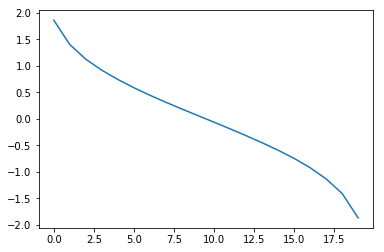

0.74072007024258


In [170]:
plt.plot(emp_peaks)
plt.show()
print(emp_peaks[4])

In [178]:
T = 20
delta = 10

MC = 100000

reduced_peaks_emp = []
reduced_peaks_exp = []

for k in range(1,T):
    reduced_peaks_mc = []
    for mc in range(MC):
        X = np.random.normal(0,1,size=(T,))
        top_i = list(reversed(np.argsort(X)))
        for cp in range(k):
            X[top_i[cp]] = X[top_i[cp]] - float(delta/float(k))
        reduced_peaks_mc.append(np.max(X))
    
    reduced_peaks_emp.append(np.mean(reduced_peaks_mc))
    
    budget = float(delta/float(k)) 
    reduce = [budget for i in range(k)] + [0 for i in range(T-k)]
    print(k, reduce)
    diff = emp_peaks - np.asarray(reduce)
    reduced_peaks_exp.append(np.max(diff))
    #while budget/k greater than expected first differences, true, then last true is expected reduced peak

1 [10.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2 [5.0, 5.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
3 [3.3333333333333335, 3.3333333333333335, 3.3333333333333335, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
4 [2.5, 2.5, 2.5, 2.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
5 [2.0, 2.0, 2.0, 2.0, 2.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
6 [1.6666666666666667, 1.6666666666666667, 1.6666666666666667, 1.6666666666666667, 1.6666666666666667, 1.6666666666666667, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
7 [1.4285714285714286, 1.4285714285714286, 1.4285714285714286, 1.4285714285714286, 1.4285714285714286, 1.4285714285714286, 1.4285714285714286, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
8 [1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
9 [1.1111111111111112, 1.1111111111111112, 1.1111111111111112, 1.1111111111111112, 1.1111111111111112, 1.1111111111111112, 1.1111111111111112, 1.1111111111111112, 1.1111111111

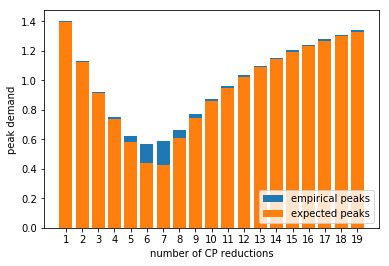

In [179]:
%matplotlib inline

plt.bar(np.arange(1,T,1,dtype=np.int32), reduced_peaks_emp, label="empirical peaks")
plt.bar(np.arange(1,T,1,dtype=np.int32), reduced_peaks_exp, label="expected peaks")
plt.xlabel("number of CP reductions")
plt.xticks([i for i in range(1,20)])
plt.ylabel("peak demand")
plt.legend(loc=4)
plt.show()

### Time dependent mean

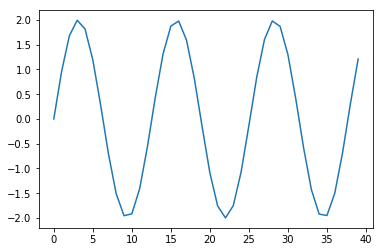

In [183]:
X = np.arange(0,40,1)
Y = 2*np.sin(0.5*X)

plt.plot(X, Y)
plt.show()

In [193]:
#for a given peak reduction budget \Delta, reduce the top K peaks according to \Delta/K

m_budget_surf = np.zeros((50,40))
T = 41
deltas = np.arange(0.2,10.2,0.2)
MC = 10000

for j in range(deltas.shape[0]):
    delta = deltas[j]
    expected_peaks = []
    for k in range(1,T):
        peak_mc = []
        for mc in range(MC):
            mean_input = np.arange(0,T,1)
            X = 2*np.sin(0.5*mean_input) + np.random.normal(0,1,size=(T,)) #mean dominates noise
            top_i = list(reversed(np.argsort(X)))
            for cp in range(k):
                X[top_i[cp]] = X[top_i[cp]] - float(delta/float(k))
            peak_mc.append(np.max(X))
        expected_peaks.append(np.mean(peak_mc))
    m_budget_surf[j,:] = expected_peaks

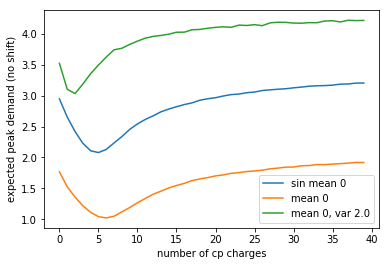

In [222]:
plt.plot(m_budget_surf[j,:], label="sin mean 0")
plt.plot(budget_surf[j,:], label="mean 0")
plt.plot(v_budget_surf[j,:], label="mean 0, var 2.0")
plt.xlabel("number of cp charges")
plt.ylabel("expected peak demand (no shift)")
plt.legend()
plt.show()

### Increased system variance vs increasing number of CP charges

In [207]:
#fix T and budget, vary cp and variance

v_budget_surf = np.zeros((50,40))
variances = np.arange(0.04,2.04,0.04)
T = 41
delta = 5
MC = 10000

for j in range(variances.shape[0]):
    v = variances[j]
    expected_peaks = []
    for k in range(1,T):
        peak_mc = []
        for mc in range(MC):
            X = np.random.normal(0,v,size=(T,))
            top_i = list(reversed(np.argsort(X)))
            for cp in range(k):
                X[top_i[cp]] = X[top_i[cp]] - float(delta/float(k))
            peak_mc.append(np.max(X))
        expected_peaks.append(np.mean(peak_mc))
    v_budget_surf[j,:] = expected_peaks


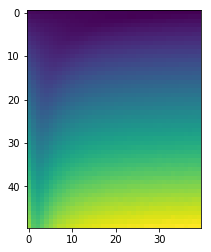

In [210]:
plt.imshow(v_budget_surf)

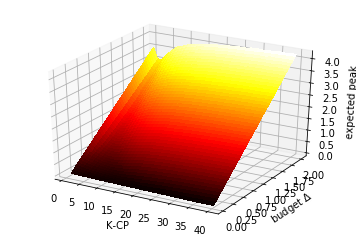

In [219]:
%matplotlib inline

Y = variances
X = np.arange(1,T,1)
X, Y = np.meshgrid(X, Y)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, v_budget_surf, rstride=1, cstride=1, cmap='hot', linewidth=0, antialiased=False)
#ax.set_zlim(-1.01, 1.01)
ax.set_xlabel('K-CP')
ax.set_ylabel('budget $\Delta$')
ax.set_zlabel('expected peak')

#fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [217]:
fig.clf()

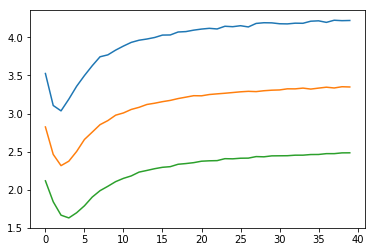

In [238]:
plt.plot(v_budget_surf[j,:])
plt.plot(v_budget_surf[j-10,:])
plt.plot(v_budget_surf[j-20,:])
plt.show()

In [267]:
#compare empirical estimation of order statistic w.r.t. number of hours with subset of of peak sin hours

#mean center 2
#T = 5

#vs sin 40 w/ amplitude 2

T_sub = 10

MC = 10000

peaks = np.zeros((MC, T_sub))

for mc in range(MC):
    X = np.random.normal(2,1.0,size=(T_sub,))
    peaks[mc] = np.asarray(sorted(X, reverse=True))
    
emp_peaks = np.mean(peaks,axis=0)


T_sin = 40

peaks_sin = np.zeros((MC, T_sin))

for mc in range(MC):
    mean_input = np.arange(0,T_sin,1)
    X = 2.0*np.sin(0.5*mean_input) + np.random.normal(0,1,size=(T_sin,))
    peaks_sin[mc] = np.asarray(sorted(X, reverse=True))
    
emp_peaks_sin = np.mean(peaks_sin, axis=0)

peaks_normal = np.zeros((MC, T_sin))

for mc in range(MC):
    X = np.random.normal(2,1,size=(T_sin,))
    peaks_normal[mc] = np.asarray(sorted(X, reverse=True))
    
emp_peaks_normal = np.mean(peaks_normal, axis=0)

In [2]:
plt.plot(emp_peaks, label="subset")
plt.plot(emp_peaks_sin, label="sin shift")
plt.plot(emp_peaks_normal, label="constant shift")
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [ ]:
#load annual ercot data
#load annual forecasted ercot data
#get distribution of forecast error

#simulate peak timing with distribution of forecast error against a year of ercot forecast data
#loop over CP with finite CP budget

